In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import pickle
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,5)

#### Prepare Rpy2-bridge needed to run some of the GLM PCAs in R

In [3]:
from rpy2 import robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri

numpy2ri.activate()

utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) 
if not rpackages.isinstalled('glmpca'):
    utils.install_packages("glmpca")
glmnet = rpackages.importr('glmpca')
glmpca = robjects.r['glmpca']

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [4]:
folder = 'datasets/33k_pbmc/'
picklefile = folder+'preprocessed.pickle'
dataset = pickle.load(open(picklefile, "rb"))
print(dataset['counts'].shape)
dataset['labelshort'] = '10X v1 33k PBMC'
counts = dataset['counts'].toarray()

(33148, 16809)


### Analytical residuals

In [14]:
from tools import  log_transform, normalize_and_scale, pearson_residuals, sqrt_lazy, sqrt_full, PCA_sklearn, kobak_tsne, run_glmpca

In [6]:
%time dataset['residuals_theta100'] = pearson_residuals(counts,100)
%time dataset['residuals_theta10'] = pearson_residuals(counts,10)

CPU times: user 10.3 s, sys: 7.18 s, total: 17.5 s
Wall time: 17.5 s
CPU times: user 11.7 s, sys: 2.52 s, total: 14.2 s
Wall time: 14.2 s


### Sqrt methods

In [7]:
%time dataset['sqrt_lazy'] = sqrt_lazy(counts)
%time dataset['sqrt_full'] = sqrt_full(counts)

CPU times: user 4.14 s, sys: 237 ms, total: 4.38 s
Wall time: 4.41 s
CPU times: user 7.38 s, sys: 4.25 s, total: 11.6 s
Wall time: 11.6 s


### Log methods

In [8]:
%time dataset['log1p_noscale'] = log_transform(counts,scale=1,scale_mode='user_provided_scale')  ### equivalent to just normalizing and no log transform
%time dataset['log1p_medianscale'] = log_transform(counts,scale_mode='median')
%time dataset['log1p_10kscale'] = log_transform(counts,scale=10000,scale_mode='user_provided_scale')

CPU times: user 6.34 s, sys: 1.09 s, total: 7.43 s
Wall time: 7.43 s
CPU times: user 6.65 s, sys: 657 ms, total: 7.3 s
Wall time: 7.3 s
CPU times: user 6.46 s, sys: 3.32 s, total: 9.78 s
Wall time: 9.78 s


### Run GLM PCA

In [9]:
def glmpca_R(data,fam,tol=10**-4,dataset_label=''):
    
    basepath = 'glmpca_results/glmpca_%s_%s_tol%s' % (dataset_label,fam,tol)
    print('will save at', basepath)
    
    #create ctl list R object for controlling glmpca
    list_r = robjects.r('list')
    ctl = list_r(tol=tol,verbose=True)

    #make use of sparsity
    Y_sparse = data.T.tocoo() ## transpose needed because glmpca wants rows as features
    r_Matrix = rpackages.importr("Matrix")
    Y_r = r_Matrix.sparseMatrix(i=robjects.IntVector(Y_sparse.row + 1),
                                j=robjects.IntVector(Y_sparse.col + 1),
                                x=robjects.IntVector(Y_sparse.data),
                                dims=robjects.IntVector(Y_sparse.shape))
    #use minibatches where possible
    if fam=='nb2':
        minibatch = 'none'
    else:
        minibatch = 'stochastic'
    

    ### Run GLM PCA in R
    robjects.r("set.seed(202)")
    
    res = glmpca(Y_r,50,fam=fam,minibatch=minibatch,ctl=ctl)

    ### Save raw
    with open(basepath + '_raw.pickle' ,"wb") as f:
        pickle.dump(res,f)

    ### Convert to python friendly shape and save
    res_dict = {name:data for name,data in res.items()}
    res_dict['ctl'] = {name:data for name,data in res_dict['ctl'].items()}
    gf = {name:data for name,data in res_dict['glmpca_family'].items()}
    res_dict.pop('glmpca_family')
    factors = res_dict['factors'].values
    with open(basepath + '_pyOnly.pickle',"wb") as f:
        pickle.dump(res_dict,f)
    with open(basepath + '_familyRattribute.pickle',"wb") as f:
        pickle.dump(gf,f)
    with open(basepath + '_factors.pickle',"wb") as f:
        pickle.dump(factors,f)

In [10]:
### GLMPCA R: Poisson, higher convergence threshold
glmpca_R(data=dataset['counts'],fam='poi',tol=10**-8,dataset_label='pbmc')
### GLMPCA R: NB, fit shared theta
glmpca_R(data=dataset['counts'],fam='nb',dataset_label='pbmc')
### GLMPCA R: NB, fit theta per gene
glmpca_R(data=dataset['counts'],fam='nb2',dataset_label='pbmc')
### GLMPCA Python: NB, fixed theta=100
run_glmpca(counts,fam='nb',optimize_nb_theta=False,theta=100,dataset_label='pbmc')

### Load GLM PCA results

In [12]:
### GLMPCA R: Poisson, higher convergence threshold
with open('glmpca_results/glmpca_pbmc_poi_tol1e-08_factors.pickle',"rb") as f:
    dataset['glmpca_poi_tol10-8'] = pickle.load(f)    
### GLMPCA R: NB, fit shared theta
with open('glmpca_results/glmpca_pbmc_nb_tol0.0001_factors.pickle',"rb") as f:
    dataset['glmpca_nb'] = pickle.load(f)    
### GLMPCA R: NB, fit theta per gene
with open('glmpca_results/glmpca_pbmc_nb2_tol0.0001_factors.pickle',"rb") as f:
    dataset['glmpca_nb2'] = pickle.load(f)
### GLMPCA Python: NB, fixed theta=100
with open('glmpca_results/pbmcglmpca-py_nb_fixedTheta100_penalty1.pickle',"rb") as f:
    dataset['glmpca_nb_thetaFixed100']= pickle.load(f)['factors']

### Compute tSNEs

In [13]:
## Prepare init
_,sqrt_lazy_init = PCA_sklearn(dataset['sqrt_lazy'],50,42)
## Compute 
_ = kobak_tsne(dataset['sqrt_lazy'],name='pbmc_sqrt_lazy_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['sqrt_full'],name='pbmc_sqrt_full_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)

_ = kobak_tsne(dataset['residuals_theta100'],name='pbmc_residuals_theta100_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['residuals_theta10'],name='pbmc_residuals_theta10_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)

_ = kobak_tsne(dataset['glmpca_poi_tol10-8'],name='pbmc_glmpca_poi_tol10-8_initsqrtLazy',do_pca=False,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['glmpca_nb'],name='pbmc_glmpca_nb_initsqrtLazy',do_pca=False,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['glmpca_nb2'],name='pbmc_glmpca_nb2_initsqrtLazy',do_pca=False,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['glmpca_nb_thetaFixed100'],name='glmpca_nb_thetaFixed100_initsqrtLazy',do_pca=False,init=sqrt_lazy_init)

_ = kobak_tsne(dataset['log1p_noscale'],name='pbmc_log1p_noscale_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['log1p_medianscale'],name='pbmc_log1p_medianscale_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)
_ = kobak_tsne(dataset['log1p_10kscale'],name='pbmc_log1p_10kscale_initsqrtLazy',do_pca=True,init=sqrt_lazy_init)

variance explained by top50 PCs: 21 %


### Downsampling Experiment

removing 0 cells and 1258 genes with zero counts


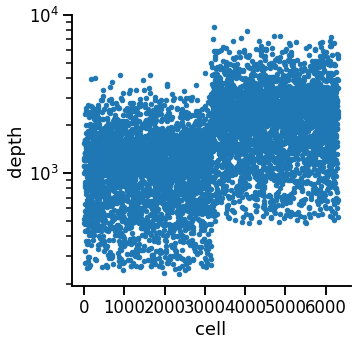

In [37]:
clusters = np.array(pd.read_csv('datasets/33k_pbmc/analysis/kmeans/10_clusters/clusters.csv')['Cluster'])
counts_downsamplingExp = counts[clusters==2,:]

#randomly pick half of the cells
group1_size = int(np.ceil(counts_downsamplingExp.shape[0]/2))
seed = 42
np.random.seed(seed)
cell_idx_shuffled = np.random.permutation(np.arange(counts_downsamplingExp.shape[0]))
cell_idx_group1 = cell_idx_shuffled[:group1_size]
cell_idx_group2 = cell_idx_shuffled[group1_size:]

counts_group1 = counts_downsamplingExp[cell_idx_group1,:].astype(int)
counts_group2 = counts_downsamplingExp[cell_idx_group2,:].astype(int)

#downsample group 1 to 50% depth
seed = 42
np.random.seed(seed)
counts_downsampled_group1 = np.random.binomial(counts_group1,0.5)

#concatenate again
counts_postdownsampling = np.concatenate((counts_downsampled_group1,counts_group2),axis=0)
#remove zero rows and columns
zero_genes_idx = np.sum(counts_postdownsampling,axis=0) == 0 
zero_cells_idx = np.sum(counts_postdownsampling,axis=1) == 0
print('removing', sum(zero_cells_idx),'cells and',sum(zero_genes_idx),'genes with zero counts')
counts_postdownsampling = counts_postdownsampling[:,~zero_genes_idx]
counts_postdownsampling = counts_postdownsampling[~zero_cells_idx,:]
depths_postdownsampling = np.sum(counts_postdownsampling,axis=1)

#plot depth per cell
with sns.plotting_context('talk'):
    plt.plot(depths_postdownsampling,'.')
    plt.xlabel('cell')
    plt.ylabel('depth')
    plt.yscale('log')
    sns.despine()

#### Apply GLM PCA

In [ ]:
run_glmpca(counts_postdownsampling,fam='nb',optimize_nb_theta=False,theta=100,dataset_label = 'pbmc_downsamplingExp_')

#### Apply other methods

In [38]:
normalized_postdownsampling = normalize_and_scale(counts_postdownsampling,scale=1)
log1p_normalized_scaleMedian_postdownsampling = log_transform(counts_postdownsampling,scale_mode='median')
log1p_normalized_scale10k_postdownsampling = log_transform(counts_postdownsampling,scale=10000,scale_mode='user_provided_scale')

sqrt_normalized_postdownsampling = sqrt_lazy(counts_postdownsampling)
pearson_residuals_postdownsampling = pearson_residuals(counts_postdownsampling,theta=100)
with open('glmpca_results/pbmc_downsamplingExp_glmpca-py_nb_fixedTheta100_penalty1.pickle','rb') as f:
    glmpca_postdownsampling = pickle.load(f)['factors']

#### Compute tSNEs

In [39]:
#get PCA of the pearson version for init
_,PCAinit = PCA_sklearn(sqrt_normalized_postdownsampling,50,42)
# compute tSNEs
_ = kobak_tsne(log1p_normalized_scale10k_postdownsampling,name='pbmc_downsamplingExp_log1p_normalized_scale10k',init=PCAinit)
_ = kobak_tsne(log1p_normalized_scaleMedian_postdownsampling,name='pbmc_downsamplingExp_log1p_normalized_scaleMedian',init=PCAinit)
_ = kobak_tsne(normalized_postdownsampling,name='pbmc_downsamplingExp_normalized',init=PCAinit)
_ = kobak_tsne(sqrt_normalized_postdownsampling,name='pbmc_downsamplingExp_sqrt_normalized',init=PCAinit)
_ = kobak_tsne(pearson_residuals_postdownsampling,name='pbmc_downsamplingExp_residuals',init=PCAinit)
_ = kobak_tsne(glmpca_postdownsampling,name='pbmc_downsamplingExp_glmpca',init=PCAinit,do_pca=False)

### Gene selection based on Analytical Pearson Residuals

#### Select genes

In [ ]:
residual_var = np.var(dataset['residuals_theta100'],axis=0)
maxvar_idx = np.argsort(residual_var)[-1000:]
counts_maxResidualVar = counts[:,maxvar_idx]
genes_maxResidualVar = dataset['genes'][maxvar_idx]

#### Compute sqrt(x), residuals, glmpca on reduced count matrix

In [ ]:
run_glmpca(counts_maxResidualVar,fam='nb',optimize_nb_theta=False,theta=100,dataset_label='pbmc_maxResidualVarSelectionExp_',penalty=5)

In [ ]:
with open('glmpca_results/pbmc_maxResidualVarSelectionExp_glmpca-py_nb_fixedTheta100_penalty5.pickle','rb') as f:
    glmpca_theta100_maxResSelection = pickle.load(f)['factors']
residuals_theta100_maxResSelection = pearson_residuals(counts_maxResidualVar,100)
sqrt_lazy_maxResSelection =sqrt_lazy(counts_maxResidualVar)

#### Compute tSNEs

In [44]:
_,sqrt_lazy_maxResSelection_init = PCA_sklearn(sqrt_lazy_maxResSelection,50,42)

_ = kobak_tsne(sqrt_lazy_maxResSelection,name='pbmc_maxResSelection_sqrt_lazy_initsqrtLazy',do_pca=True,init=sqrt_lazy_maxResSelection_init)
_ = kobak_tsne(residuals_theta100_maxResSelection,name='pbmc_maxResSelection_residuals_theta100_initsqrtLazy',do_pca=True,init=sqrt_lazy_maxResSelection_init)
_ = kobak_tsne(glmpca_theta100_maxResSelection,name='pbmc_maxResSelection_glmpca_nb_thetaFixed100_initsqrtLazy',do_pca=False,init=sqrt_lazy_maxResSelection_init)